In [1]:
import glob
import os
import sys
import numpy as np
from scipy import stats
from scipy import io as sio
import scipy.spatial.distance as sp_distance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import pandas as pd
import pickle


from brainiak.isc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io
from brainiak.isc import isc
import brainiak.funcalign.srm
from brainiak import image, io
from brainiak.eventseg.event import EventSegment
import matplotlib.patches as patches


In [2]:
# Define the paths
base_path = "/Volumes/ARCHIVES/thesis_pipeline"
srm_data_path = os.path.join(base_path, "SRM_data")

# Define the ROI name
roi_name = 'IFG'

# Function to load shared response data and compute correlation matrix
def compute_and_visualize_correlation_matrix(roi_name):
    shared_data_file = os.path.join(srm_data_path, f"{roi_name}_shareddata.pkl")
    
    if os.path.exists(shared_data_file):
        with open(shared_data_file, 'rb') as file:
            shared_data = pickle.load(file)

        shared_response = shared_data[0]
        
        # Compute the correlation matrix
        corr_mat = np.corrcoef(shared_response.T)
        
        # Plot the correlation matrix
        plt.figure(figsize=(10, 8))
        plt.title(f'Correlation TRxTR matrix in shared space for {roi_name}')
        plt.xlabel('TR')
        plt.ylabel('TR')
        plt.imshow(corr_mat, cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.show()
    else:
        print(f"Shared data file for {roi_name} not found.")



# Compute and visualize correlation matrix for the IFG region
compute_and_visualize_correlation_matrix(roi_name)

In [3]:
# Function to fit HMM model for a given ROI and plot various diagnostics
def HMM_fit(roi_region):
    shared_data_file = os.path.join(srm_data_path, f"{roi_region}_shareddata.pkl")
    
    if os.path.exists(shared_data_file):
        with open(shared_data_file, 'rb') as file:
            shared_data = pickle.load(file)
        
        shared_response = shared_data[0]

        # Fit HMM to the shared response data
        n_states = 36 
        hmm_model = EventSegment(n_states)

        print(f"Fitting HMM model with {n_states} states for {roi_region}...")
        hmm_model.fit(shared_response.T)  # Transpose if data is [TRs x voxels]
        
        # Predict event segmentation
        event_segmentation = hmm_model.predict(shared_response.T)

        # Plotting the log-likelihood during training
        plt.figure(figsize=(12, 4))
        plt.plot(hmm_model.ll_)
        plt.title(f'Log likelihood during training for {roi_region}')
        plt.xlabel('Model fitting steps')
        plt.ylabel('Log likelihood')
        plt.show()
        
        # Improved mean activity plot across events for sample voxels
        plt.figure(figsize=(12, 4))
        example_voxels = np.linspace(0, hmm_model.event_pat_.shape[0] - 1, 50, dtype=int)
        plt.imshow(hmm_model.event_pat_[example_voxels, :], aspect='auto', cmap='viridis')
        plt.title(f'Mean activity across events for 50 sample voxels in {roi_region}')
        plt.xlabel('Event number')
        plt.ylabel('Voxel index')
        plt.colorbar()
        plt.show()

    
        # Plot probability of being in each event at each timepoint
        plt.figure(figsize=(12, 6))
        plt.matshow(hmm_model.segments_[0].T, aspect='auto')
        plt.gca().xaxis.tick_bottom()
        plt.colorbar()
        plt.title(f'Event probability across timepoints (TRs) in {roi_region}')
        plt.show()
        
    else:
        print(f"Shared data file for {roi_region} not found.")  

Fitting HMM model with 36 states for IFG...


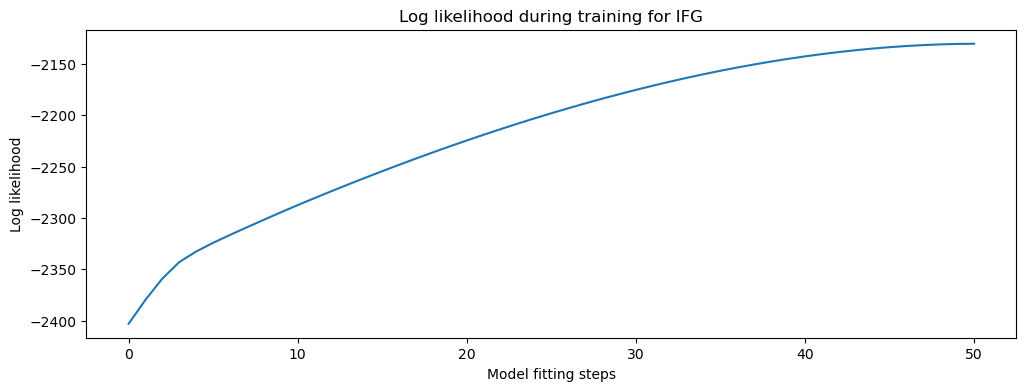

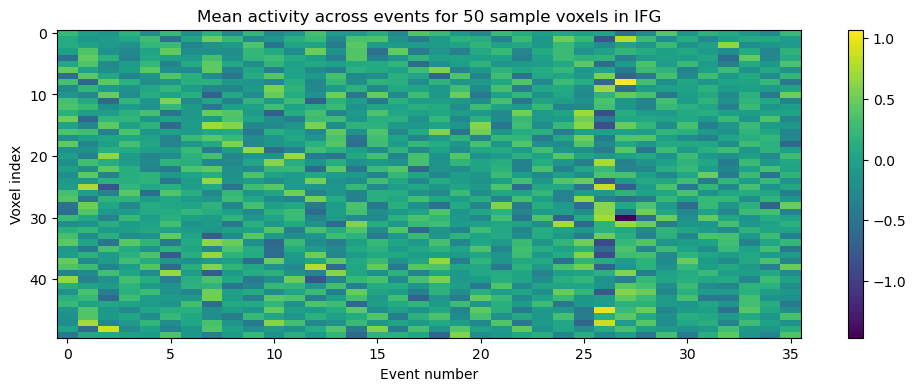

<Figure size 1200x600 with 0 Axes>

In [4]:
HMM_fit('IFG')

Fitting HMM model with 36 states for ATL...


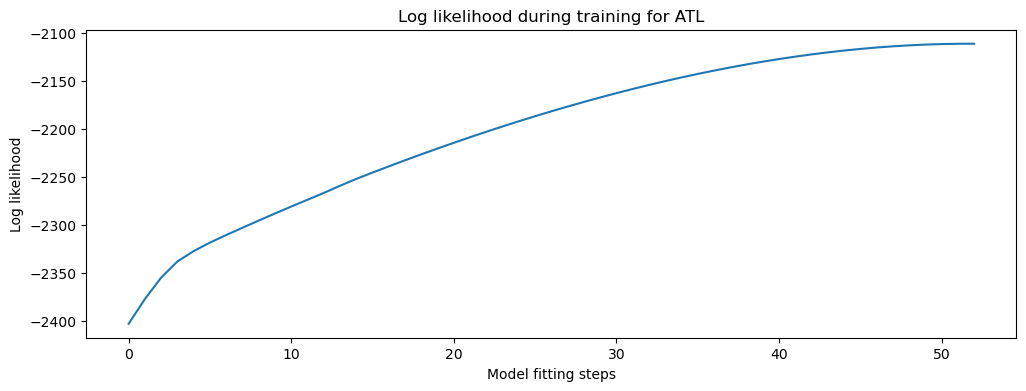

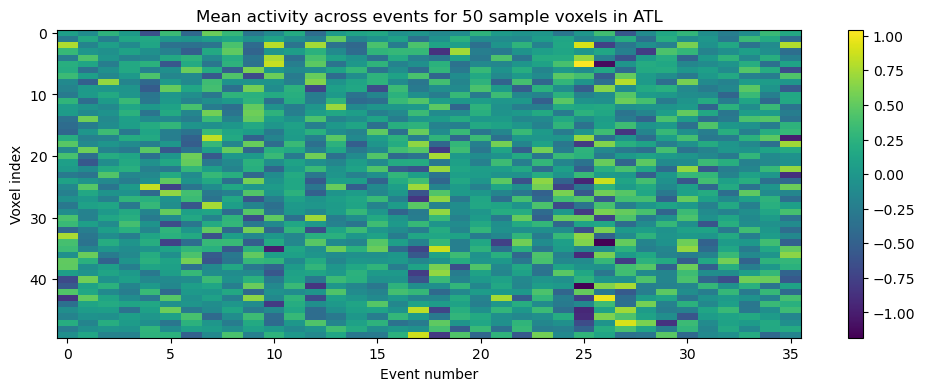

<Figure size 1200x600 with 0 Axes>

In [5]:
HMM_fit('ATL')

Fitting HMM model with 36 states for IFGorb...


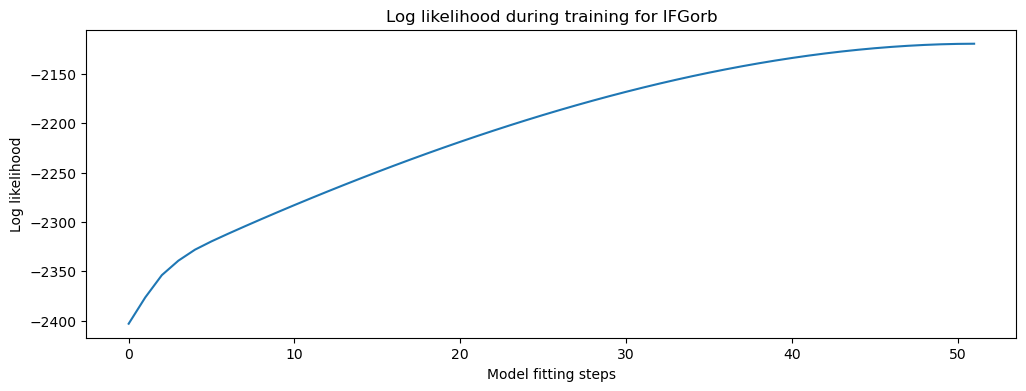

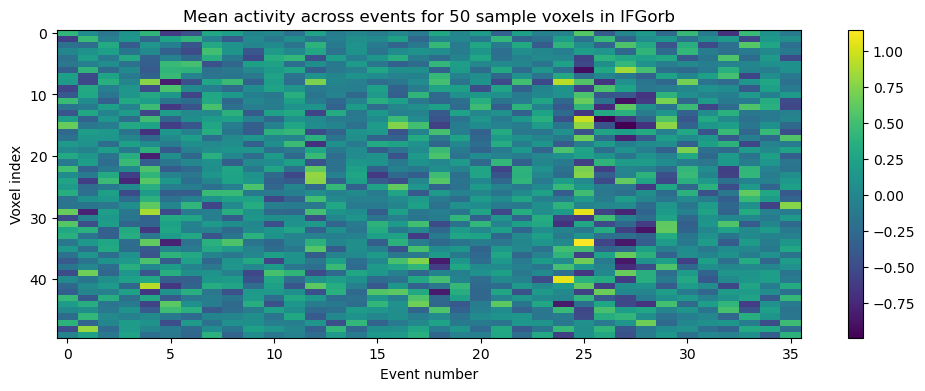

<Figure size 1200x600 with 0 Axes>

In [6]:
HMM_fit('IFGorb')

Fitting HMM model with 36 states for PTL...


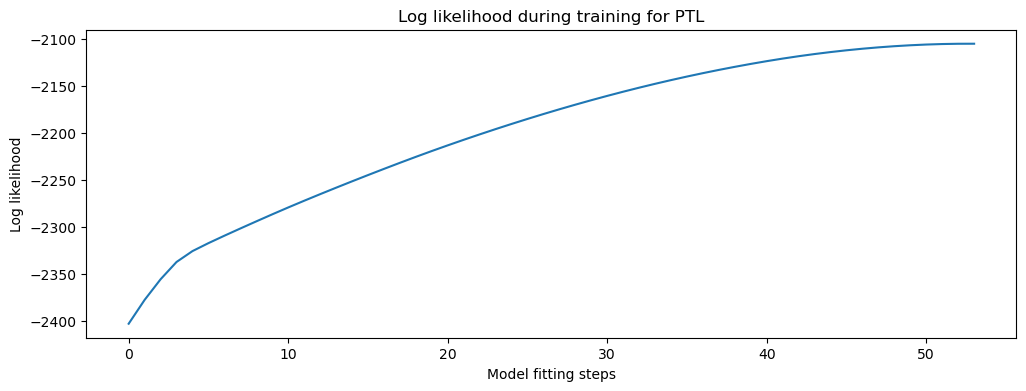

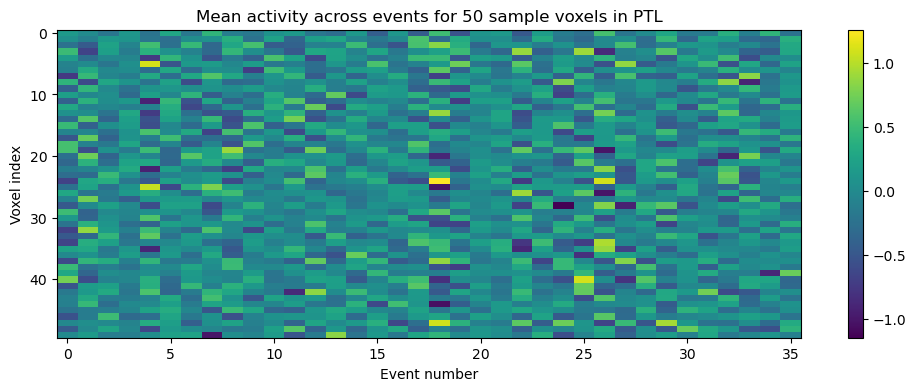

<Figure size 1200x600 with 0 Axes>

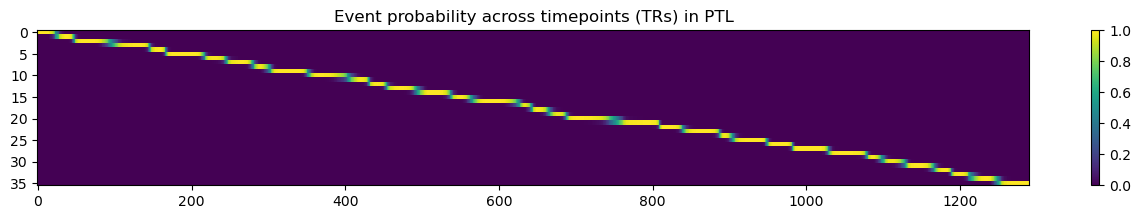

In [7]:
HMM_fit('PTL')

Fitting HMM model with 36 states for MFG...


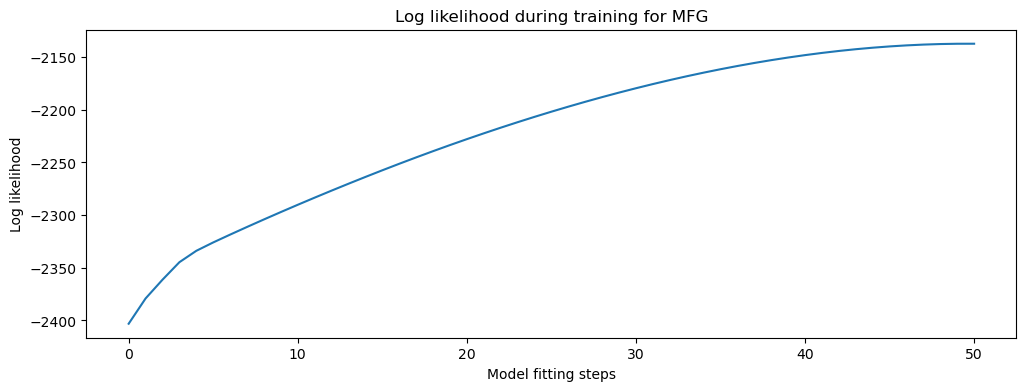

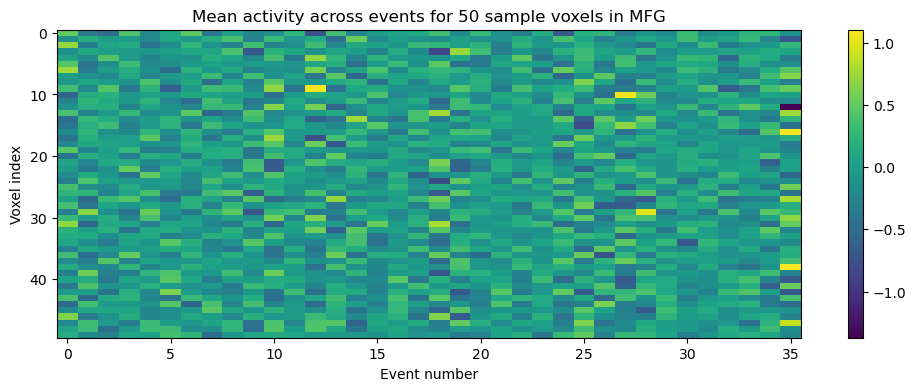

<Figure size 1200x600 with 0 Axes>

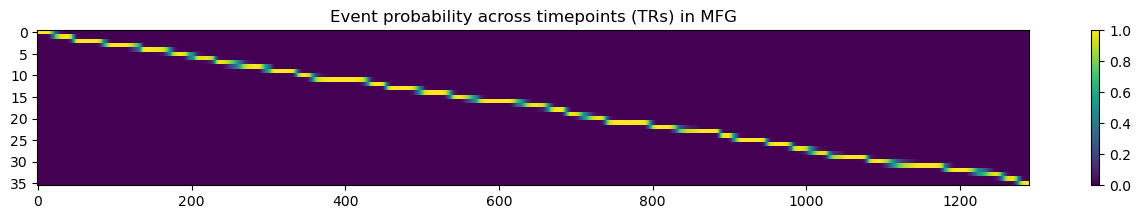

In [8]:
HMM_fit('MFG')

In [9]:

# Corrected function to generate a subplot with subjects as rows and ROIs as columns
def HMM_structure_overlay(roi_names, n_subjects):
    n_rois = len(roi_names)
    n_rows = n_subjects
    n_cols = n_rois
    
    # Create a larger subplot for all subjects (rows) and ROIs (columns)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))  # Adjust figure size accordingly
    axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array for easy indexing
    
    for subj_idx in range(n_subjects):
        for idx, roi_region in enumerate(roi_names):
            shared_data_file = os.path.join('/Volumes/ARCHIVES/thesis_pipeline/SRM_data/', f"{roi_region}_shareddata.pkl")

            if os.path.exists(shared_data_file):
                with open(shared_data_file, 'rb') as file:
                    shared_data = pickle.load(file)

                # Extract the shared response for the specific subject
                shared_response = shared_data[subj_idx]

                # Fit HMM to the shared response data
                n_states = 37
                hmm_model = EventSegment(n_states)

                print(f"Fitting HMM model with {n_states} states for {roi_region}, Subject {subj_idx + 1}...")
                hmm_model.fit(shared_response.T)  # Transpose if data is [TRs x voxels]

                # Identify event boundaries
                event_bounds = np.where(np.diff(np.argmax(hmm_model.segments_[0], axis=1)))[0]
                n_TRs = shared_response.shape[1]

                # Save HMM event segmentation data for each subject and ROI
                segment_data_dir = '/Volumes/ARCHIVES/thesis_pipeline/data/hmm_segment_data_fixed'
                os.makedirs(segment_data_dir, exist_ok=True)
                segment_file = os.path.join(segment_data_dir, f'{roi_region}_subject_{subj_idx + 1}_segments.npy')
                np.save(segment_file, event_bounds)

                # Plot the TR-TR correlation matrix with event boundaries overlay
                title_text = f'Subject {subj_idx + 1} - {roi_region}'
                axs[subj_idx * n_cols + idx].imshow(np.corrcoef(shared_response.T), cmap='viridis')
                axs[subj_idx * n_cols + idx].set_title(title_text)
                axs[subj_idx * n_cols + idx].set_xlabel('TR')
                axs[subj_idx * n_cols + idx].set_ylabel('TR')

                # Plot the boundaries as boxes
                bounds_aug = np.concatenate(([0], event_bounds, [n_TRs]))
                for i in range(len(bounds_aug) - 1):
                    rect = patches.Rectangle(
                        (bounds_aug[i], bounds_aug[i]),
                        bounds_aug[i+1] - bounds_aug[i],
                        bounds_aug[i+1] - bounds_aug[i],
                        linewidth=2, edgecolor='w', facecolor='none'
                    )
                    axs[subj_idx * n_cols + idx].add_patch(rect)

            else:
                print(f"Shared data file for {roi_region} not found.")
                axs[subj_idx * n_cols + idx].set_title(f"{roi_region} data not found")
                axs[subj_idx * n_cols + idx].axis('off')  # Hide the axis if data is not found

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the large plot (subjects by ROI arrangement)
    figure_save_path = '/Volumes/ARCHIVES/thesis_pipeline/figures/all_subject_segments_roi_by_subject.png'
    plt.savefig(figure_save_path, dpi=300)

    # Show the plot
    plt.show()


Fitting HMM model with 37 states for PTL, Subject 1...
Fitting HMM model with 37 states for ATL, Subject 1...
Fitting HMM model with 37 states for AG, Subject 1...
Fitting HMM model with 37 states for IFG, Subject 1...
Fitting HMM model with 37 states for MFG, Subject 1...
Fitting HMM model with 37 states for IFGorb, Subject 1...
Fitting HMM model with 37 states for PTL, Subject 2...
Fitting HMM model with 37 states for ATL, Subject 2...
Fitting HMM model with 37 states for AG, Subject 2...
Fitting HMM model with 37 states for IFG, Subject 2...
Fitting HMM model with 37 states for MFG, Subject 2...
Fitting HMM model with 37 states for IFGorb, Subject 2...
Fitting HMM model with 37 states for PTL, Subject 3...
Fitting HMM model with 37 states for ATL, Subject 3...
Fitting HMM model with 37 states for AG, Subject 3...
Fitting HMM model with 37 states for IFG, Subject 3...
Fitting HMM model with 37 states for MFG, Subject 3...
Fitting HMM model with 37 states for IFGorb, Subject 3...
Fitt

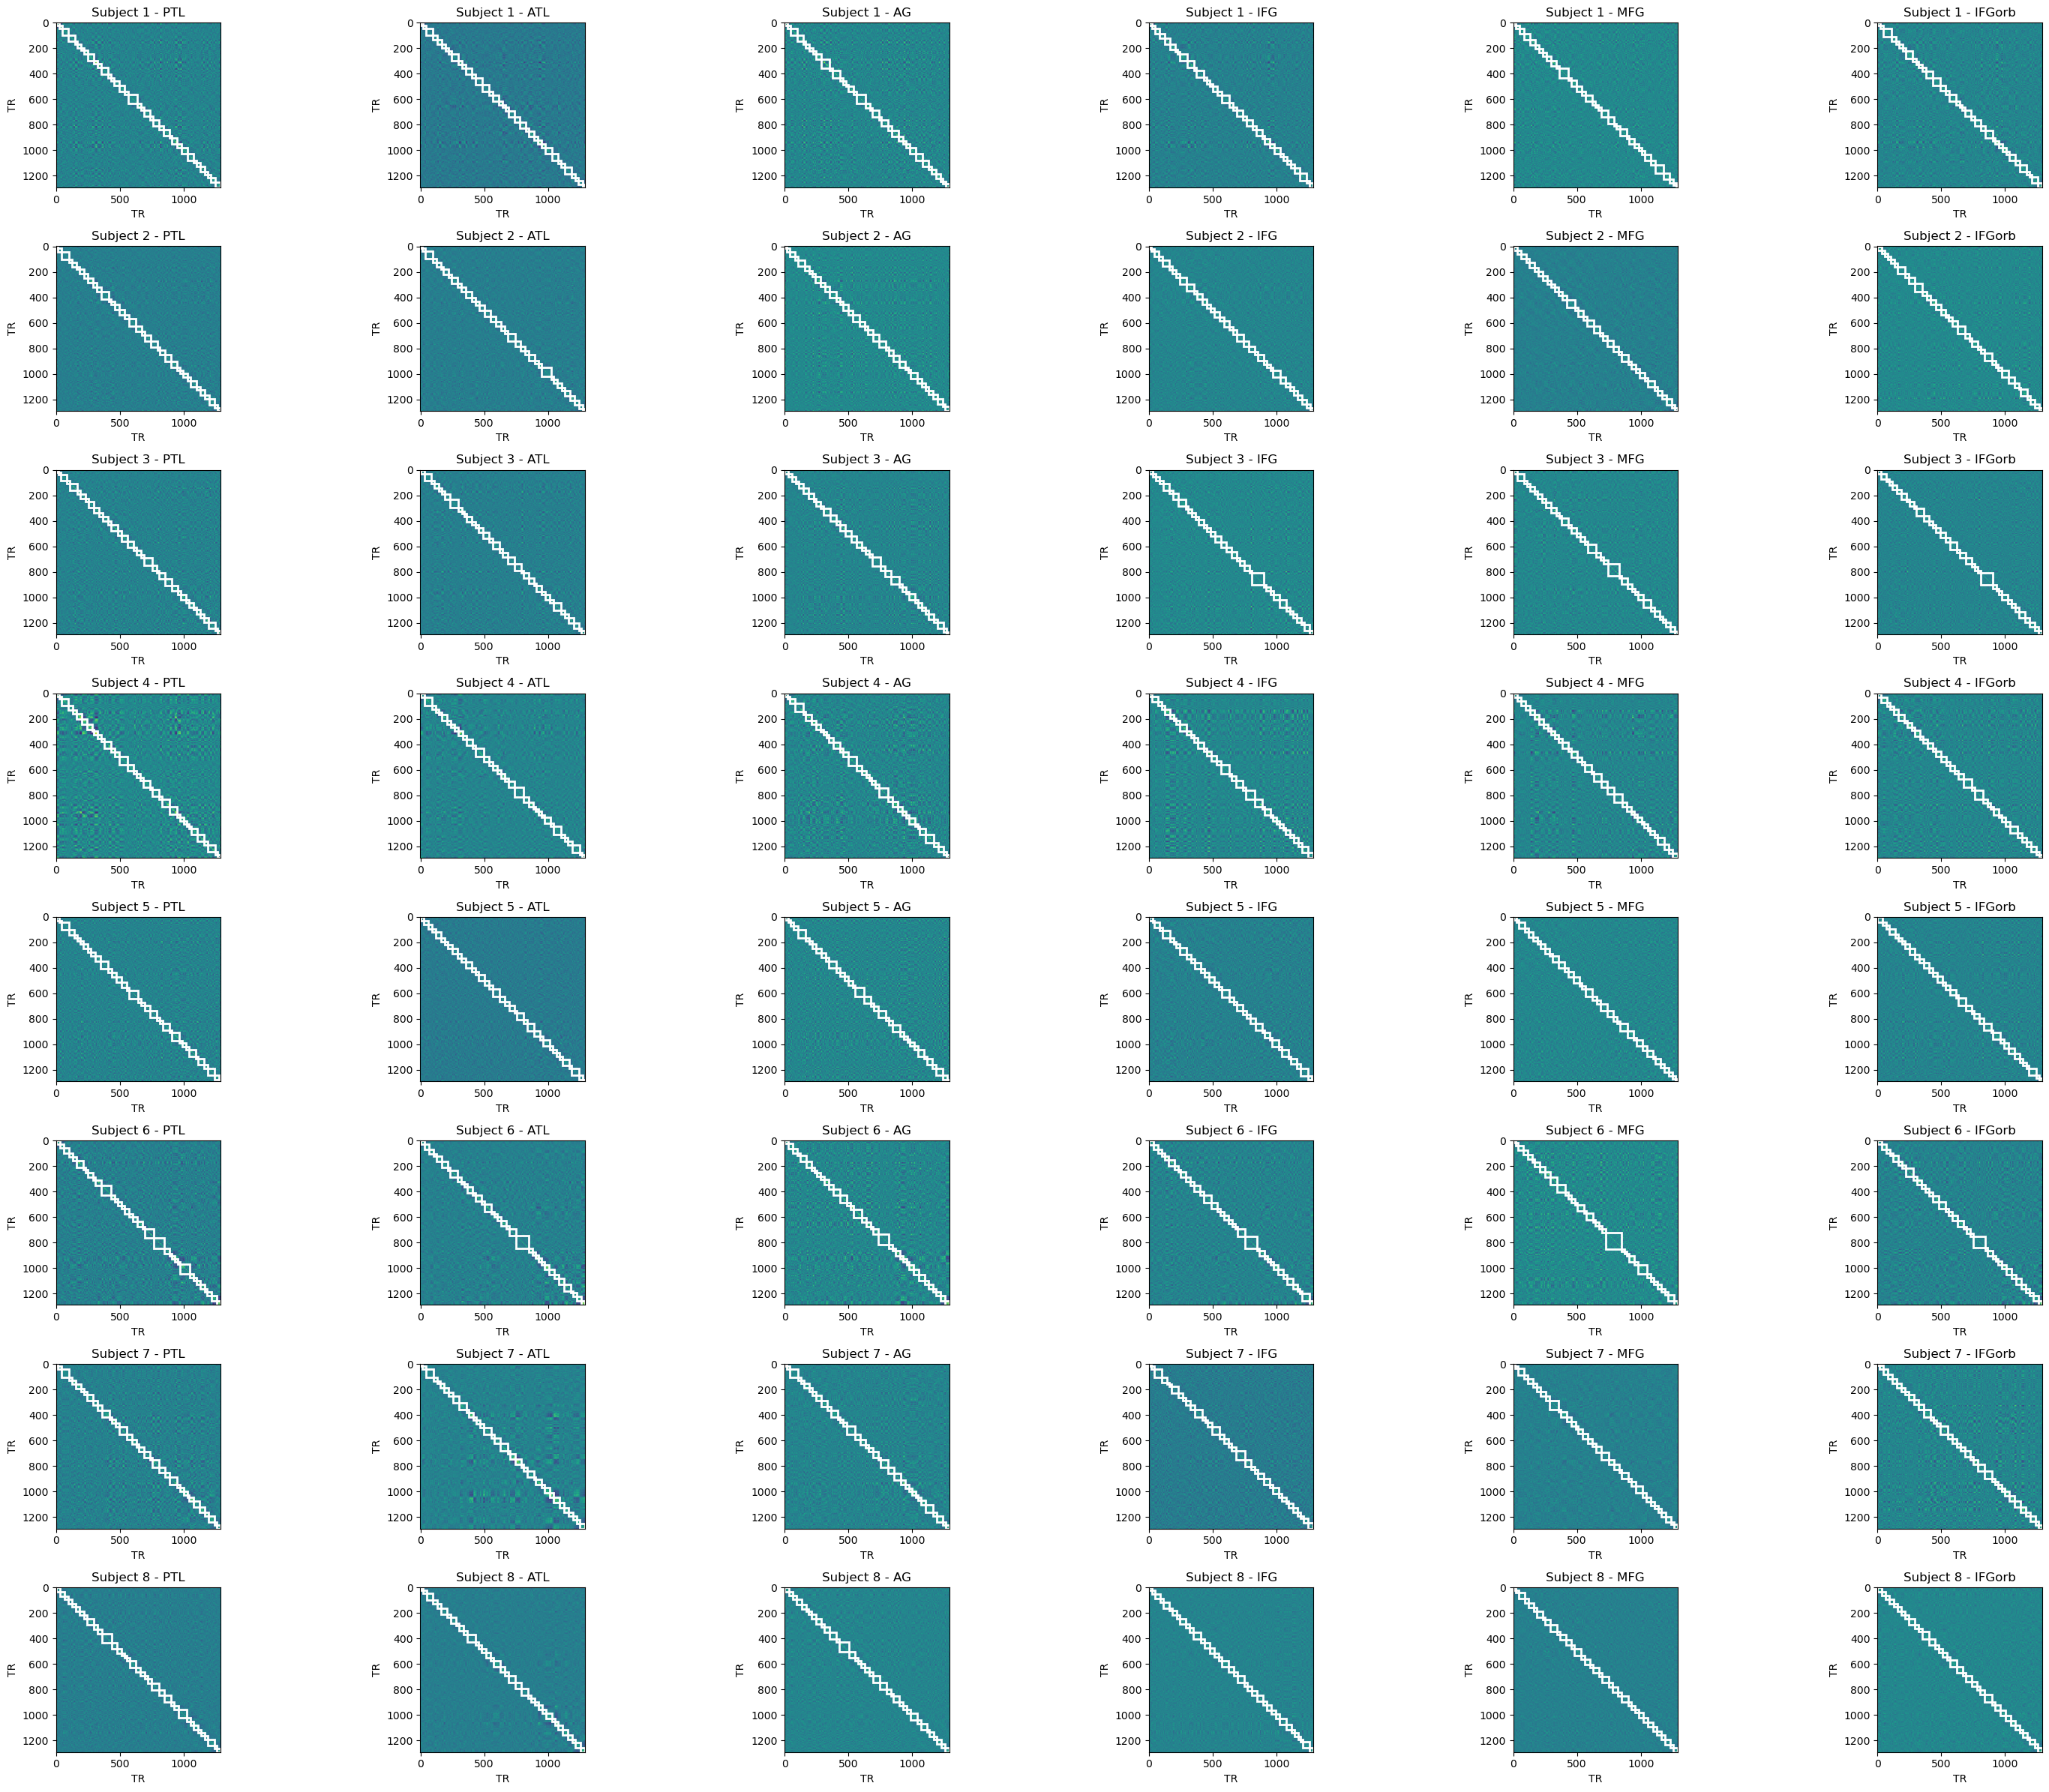

In [10]:
roi_names = ['PTL', 'ATL', 'AG', 'IFG', 'MFG', 'IFGorb']
HMM_structure_overlay(roi_names, 8)

